# Frontal Detection Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
# Previously: needed cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
# This was resolved in nc-time-axis 1.3.0 (https://github.com/SciTools/nc-time-axis/releases/tag/v1.3.0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='05:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 20 nodes (20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41230,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read and process fronts given input file

In [4]:
def process_fronts(path, file):
    fronts_ds = xr.open_dataset(path+file, chunks={'time':360})
    fronts = fronts_ds.fronts
    allfronts = fronts.argmax(dim='front')
    anyfront = allfronts.where(allfronts < 4)
    return(anyfront)

In [5]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
fronts_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"
fronts_full = process_fronts(cesm_fronts_filepath, fronts_file)

In [6]:
# subset for 2000-2014 for a 15-year climatology
#fronts = fronts_full.sel(time = slice("2000-01-01 03:00:00","2014-12-31 21:00:00")) # this doesn't work, don't know why (maybe cftime indexing?)
fronts = fronts_full[:43800]
fronts

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<getitem, shape=(43800, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

In [7]:
fronts_file_rcp = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"
fronts_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)
fronts_rcp

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<where, shape=(43800, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

In [8]:
# testing some alternates to calculate PEx
path = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc'
PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})

In [14]:
# units didn't save out after regridding; PRECT is m/s at 3hrly averages
convert=1000*60*60*3 # convert m/s to mm in each 3hr period
PRECT_1deg_day = (PRECT_1deg*convert).resample(time="1D").sum() # resample to daily values and sum over each day

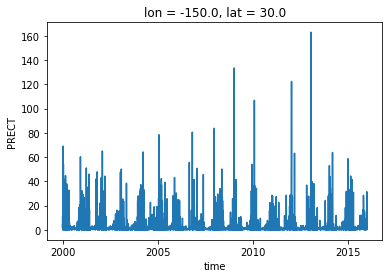

In [16]:
PRECT_1deg_day.sel(lat=30,lon=-150).plot()

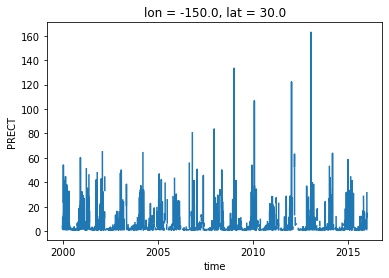

In [17]:
# filter out days with <1mm total precip
PRECT_1deg_day_filter = PRECT_1deg_day.where(PRECT_1deg_day > 1)
PRECT_1deg_day_filter.sel(lat=30,lon=-150).plot()

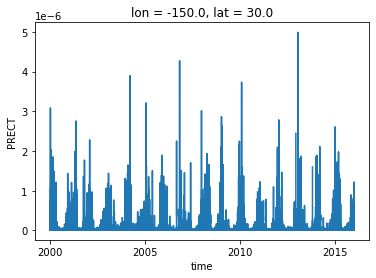

In [23]:
# problem is this is a daily timeseries, and I would need to isolate the filtered out days and remove them from PRECT_1deg timeseries which is 3hrly
#PRECT_1deg.where(PRECT_1deg_day > 1) # this works but it gives me a daily timeseries
PRECT_1deg_filter = PRECT_1deg.where((PRECT_1deg*convert) > 1/8) # here, remove 3hrly timesteps with <1/8 mm assuming even spread (8 time steps per day)
PRECT_1deg_filter.sel(lat=30,lon=-150).plot()
# but is this fair to then later look at monthly climatologies because only certain 3hrly timesteps are removed (could be only part of a day)?
# makes the results very noisy, probably due to the uneven temporal sampling

## Read and process extreme precipitation given input file and percentile

In [8]:
def process_PEx(path, file, percentile):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # remove low PRECT amounts (optional, not sure this is advisable as done here)
    #convert = 1000*60*60*3 # convert m/s to mm in each 3hr period
    #PRECT_1deg = PRECT_1deg.where((PRECT_1deg*convert) > 1/8) # here, remove 3hrly timesteps with <1/8 mm assuming even spread (8 time steps per day)
    
    quantile = percentile/100
    
    # PEx over space
    pX = PRECT_1deg.chunk({'time': -1}).quantile(quantile, dim='time')
    PEx = PRECT_1deg.where(PRECT_1deg > pX)
    # subset for CONUS
    PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(-125,-68))
    
    # PEx over time
    pX_time = PRECT_1deg.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    PEx_time = PRECT_1deg.where(PRECT_1deg > pX_time)
    
    # subset for CONUS, starting from quantile calculation since it's looking over space
    pX_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)) > pX_time_CONUS)
    
    return(PEx, PEx_CONUS, PEx_time, PEx_time_CONUS)

In [37]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc'
# toggle this to test different PEx definitions
percentile = 99
PEx, PEx_CONUS, PEx_time, PEx_time_CONUS = process_PEx(postprocessing_filepath, PRECT_file, percentile)
PEx

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,17081 Tasks,4088 Chunks
Type,float64,numpy.ndarray


In [38]:
# modify processing function to account for using a different baseline
def process_PEx_base(path, file, basefile, percentile):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    PRECT_1deg_base = xr.open_dataarray(path+basefile, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    if PRECT_1deg_base.shape[0] > 43800:
        PRECT_1deg_base = PRECT_1deg_base[:43800]

    quantile = percentile/100
    
    # PEx over space
    #pX = PRECT_1deg.chunk({'time': -1}).quantile(quantile, dim='time')
    pX = PRECT_1deg_base.chunk({'time': -1}).quantile(quantile, dim='time') # use the baseline file to define the percentile
    PEx = PRECT_1deg.where(PRECT_1deg > pX)
    # subset for CONUS
    PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(-125,-68))
    
    # PEx over time
    #pX_time = PRECT_1deg.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    pX_time = PRECT_1deg_base.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    # copy the time attribute from PRECT_1deg to pX_time so they will match
    pX_time = pX_time.assign_coords(time=PRECT_1deg.time)
    PEx_time = PRECT_1deg.where(PRECT_1deg > pX_time) 
    
    # subset for CONUS, starting from quantile calculation since it's looking over space
    #pX_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    pX_time_CONUS = PRECT_1deg_base.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    pX_time_CONUS = pX_time_CONUS.assign_coords(time=PRECT_1deg.time)
    PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)) > pX_time_CONUS)
    
    return(PEx, PEx_CONUS, PEx_time, PEx_time_CONUS)

In [39]:
PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
PEx_rcp, PEx_CONUS_rcp, PEx_time_rcp, PEx_time_CONUS_rcp = process_PEx_base(postprocessing_filepath, file=PRECT_file_rcp, basefile=PRECT_file, percentile=percentile)
PEx_rcp

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,21170 Tasks,4088 Chunks
Type,float64,numpy.ndarray


## Calculate percent gridpoints that overlap given fronts and PEx
Also return PEx gridpoints

In [40]:
def calc_overlap_space(fronts,PEx):
    PEx_front = PEx.where(fronts.notnull())
    
    PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))
    overlap = PEx_front.notnull().sum(dim=('lat','lon'))
    npercentPEx = 100*(overlap/PExgridpoints)
    
    return(npercentPEx, PExgridpoints)

In [41]:
npercentPEx_space, PExgridpoints_space = calc_overlap_space(fronts, PEx)
npercentPEx_space_CONUS, PExgridpoints_space_CONUS = calc_overlap_space(fronts, PEx_CONUS)
npercentPEx_space_rcp, PExgridpoints_space_rcp = calc_overlap_space(fronts_rcp, PEx_rcp)
npercentPEx_space_CONUS_rcp, PExgridpoints_space_CONUS_rcp = calc_overlap_space(fronts_rcp, PEx_CONUS_rcp)

In [42]:
def calc_overlap_time(fronts,PEx):
    PEx_front = PEx.where(fronts.notnull())
    
    PExgridpoints = PEx.notnull().sum(dim='time')
    overlap = PEx_front.notnull().sum(dim='time')
    npercentPEx = 100*(overlap/PExgridpoints)
    
    PExgridpoints_byseason = PEx.notnull().groupby("time.season").sum(dim='time') # by season (4; DJF, JJA, MAM, SON)
    overlap_byseason = PEx_front.notnull().groupby("time.season").sum(dim='time')
    npercentPEx_byseason = 100*(overlap_byseason/PExgridpoints_byseason)
    
    return(npercentPEx, npercentPEx_byseason, PExgridpoints, PExgridpoints_byseason)

In [43]:
npercentPEx_time, npercentPEx_time_byseason, PExgridpoints_time, PExgridpoints_time_byseason = calc_overlap_time(fronts, PEx_time)
npercentPEx_time_CONUS, npercentPEx_time_CONUS_byseason, PExgridpoints_time_CONUS, PExgridpoints_time_CONUS_byseason = calc_overlap_time(fronts, PEx_time_CONUS)
npercentPEx_time_rcp, npercentPEx_time_byseason_rcp, PExgridpoints_time_rcp, PExgridpoints_time_byseason_rcp = calc_overlap_time(fronts_rcp, PEx_time_rcp)
npercentPEx_time_CONUS_rcp, npercentPEx_time_CONUS_byseason_rcp, PExgridpoints_time_CONUS_rcp, PExgridpoints_time_CONUS_byseason_rcp = calc_overlap_time(fronts_rcp, PEx_time_CONUS_rcp)

### Climatological monthly mean plots

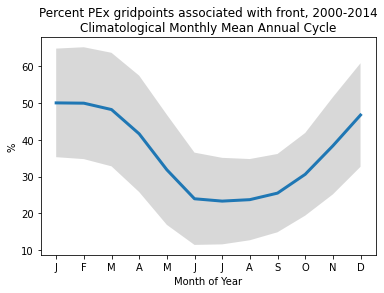

In [44]:
npercentPEx_monthofyear = npercentPEx_space.groupby("time.month").mean().persist()
npercentPEx_monthofyear_std = npercentPEx_space.groupby("time.month").std().persist()

plt.plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2014\nClimatological Monthly Mean Annual Cycle');

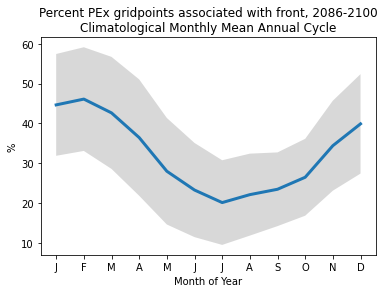

In [45]:
npercentPEx_rcp85_monthofyear = npercentPEx_space_rcp.groupby("time.month").mean().persist()
npercentPEx_rcp85_monthofyear_std = npercentPEx_space_rcp.groupby("time.month").std().persist()

plt.plot(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');

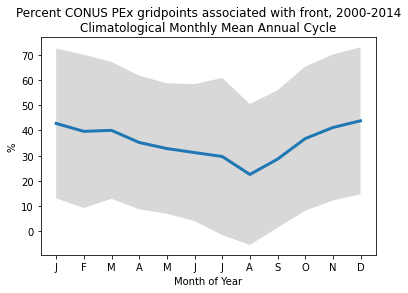

In [46]:
npercentPEx_monthofyear_CONUS = npercentPEx_space_CONUS.groupby("time.month").mean().persist()
npercentPEx_monthofyear_std_CONUS = npercentPEx_space_CONUS.groupby("time.month").std().persist()

plt.plot(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS-npercentPEx_monthofyear_std_CONUS, 
                npercentPEx_monthofyear_CONUS+npercentPEx_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front, 2000-2014\nClimatological Monthly Mean Annual Cycle');

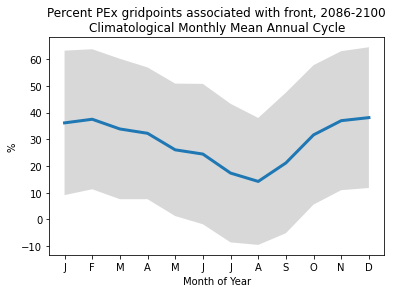

In [47]:
npercentPEx_rcp85_monthofyear_CONUS = npercentPEx_space_CONUS_rcp.groupby("time.month").mean().persist()
npercentPEx_rcp85_monthofyear_std_CONUS = npercentPEx_space_CONUS_rcp.groupby("time.month").std().persist()

plt.plot(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS-npercentPEx_rcp85_monthofyear_std_CONUS, 
                npercentPEx_rcp85_monthofyear_CONUS+npercentPEx_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');

In [48]:
# calculate differences, rcp-hist
npercentPEx_monthofyear_CONUS_diff = npercentPEx_rcp85_monthofyear_CONUS - npercentPEx_monthofyear_CONUS
npercentPEx_monthofyear_diff = npercentPEx_rcp85_monthofyear - npercentPEx_monthofyear

### Panel the climatology plots

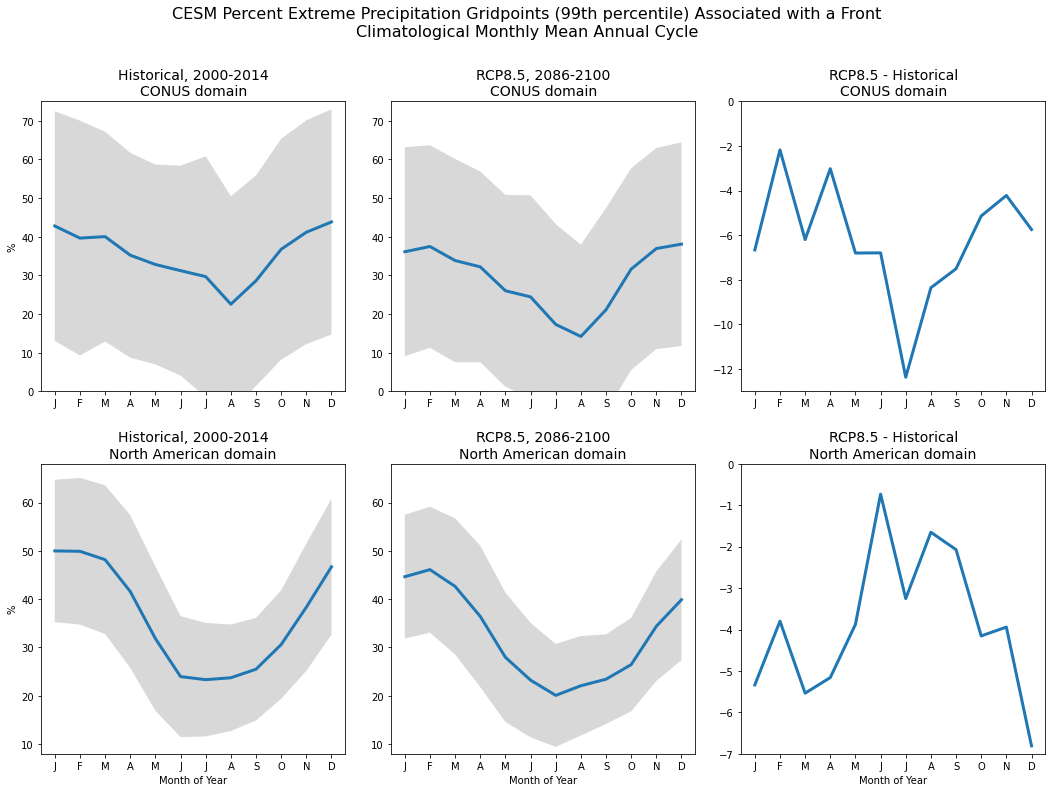

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(18,12))

# CONUS, hist
axs[0,0].plot(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS, linewidth=3)
axs[0,0].fill_between(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS-npercentPEx_monthofyear_std_CONUS, 
                npercentPEx_monthofyear_CONUS+npercentPEx_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,0].set_xticks(np.arange(12)+1)
axs[0,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,0].set_ylim(10,50) # 90th
#axs[0,0].set_ylim(5,60) # 95th
axs[0,0].set_ylim(0,75) # 99th
axs[0,0].set_ylabel('%')
axs[0,0].set_title('Historical, 2000-2014\nCONUS domain', fontsize=14)

# CONUS, rcp
axs[0,1].plot(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS, linewidth=3)
axs[0,1].fill_between(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS-npercentPEx_rcp85_monthofyear_std_CONUS, 
                npercentPEx_rcp85_monthofyear_CONUS+npercentPEx_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,1].set_xticks(np.arange(12)+1) 
axs[0,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,1].set_ylim(10,50)
#axs[0,1].set_ylim(5,60)
axs[0,1].set_ylim(0,75)
axs[0,1].set_title('RCP8.5, 2086-2100\nCONUS domain', fontsize=14);

# CONUS, diff
axs[0,2].plot(npercentPEx_monthofyear_CONUS_diff.month, npercentPEx_monthofyear_CONUS_diff, linewidth=3)
#axs[0,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[0,2].set_xticks(np.arange(12)+1) 
axs[0,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,2].set_ylim(-5,0)
#axs[0,2].set_ylim(-7,0)
axs[0,2].set_ylim(-13,0)
axs[0,2].set_title('RCP8.5 - Historical\nCONUS domain', fontsize=14);

# NA, hist
axs[1,0].plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
axs[1,0].fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,0].set_xticks(np.arange(12)+1)
axs[1,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,0].set_xlabel('Month of Year')
#axs[1,0].set_ylim(12,40)
#axs[1,0].set_ylim(10,50)
axs[1,0].set_ylim(8,68)
axs[1,0].set_ylabel('%')
axs[1,0].set_title('Historical, 2000-2014\nNorth American domain', fontsize=14);

# NA, rcp
axs[1,1].plot(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear, linewidth=3)
axs[1,1].fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,1].set_xticks(np.arange(12)+1)
axs[1,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,1].set_xlabel('Month of Year')
#axs[1,1].set_ylim(12,40)
#axs[1,1].set_ylim(10,50)
axs[1,1].set_ylim(8,68)
axs[1,1].set_title('RCP8.5, 2086-2100\nNorth American domain', fontsize=14);

# NA, diff
axs[1,2].plot(npercentPEx_monthofyear_diff.month, npercentPEx_monthofyear_diff, linewidth=3)
#axs[1,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[1,2].set_xticks(np.arange(12)+1) 
axs[1,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,2].set_xlabel('Month of Year')
#axs[1,2].set_ylim(-6,0)
#axs[1,2].set_ylim(-7,0)
axs[1,2].set_ylim(-7,0)
axs[1,2].set_title('RCP8.5 - Historical\nNorth American domain', fontsize=14);

#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (95th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (99th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)

plt.subplots_adjust(wspace=0.15, hspace=0.25)

#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_compare_withdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_monthofyear_compare_withdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_monthofyear_compare_withdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')
plt.savefig('../figures/toSCP/npercentPEx99_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')

### Seasonal spatial plots

Northern Hemisphere domain

In [44]:
# persist the data 
npercentPEx_time_byseason = npercentPEx_time_byseason.persist()
npercentPEx_time_byseason_rcp = npercentPEx_time_byseason_rcp.persist()

In [45]:
npercentPEx_time_byseason.max().values

array(100.)

In [46]:
npercentPEx_time_byseason_rcp.max().values

array(100.)

In [47]:
# difference
npercentPEx_time_byseason_diff = npercentPEx_time_byseason_rcp - npercentPEx_time_byseason

In [48]:
npercentPEx_time_byseason_diff.max().values

array(100.)

In [49]:
npercentPEx_time_byseason_diff.min().values

array(-100.)

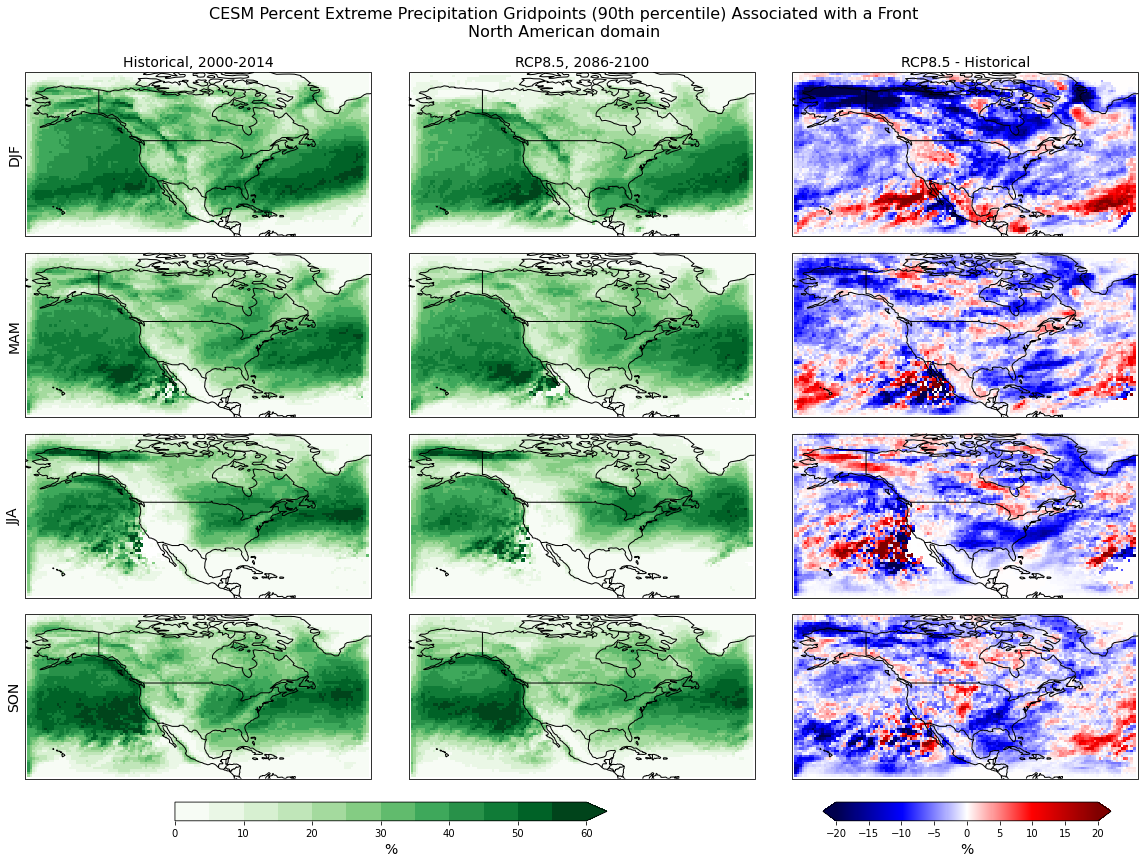

In [51]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 60

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_time_byseason.sel(season=season), coord=npercentPEx_time_byseason.lon)
    lat = npercentPEx_time_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_byseason_rcp.sel(season=season), coord=npercentPEx_time_byseason_rcp.lon)
    lat = npercentPEx_time_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-20
vmax2=20

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_byseason_diff.sel(season=season), coord=npercentPEx_time_byseason_diff.lon)
    lat = npercentPEx_time_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nNorth American domain', fontsize=16, y=0.95)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_byseason_diff_alterbase.png', bbox_inches='tight')

CONUS domain

In [51]:
npercentPEx_time_CONUS_byseason = npercentPEx_time_CONUS_byseason.persist()
npercentPEx_time_CONUS_byseason_rcp = npercentPEx_time_CONUS_byseason_rcp.persist()

In [55]:
npercentPEx_time_CONUS_byseason.max().values

array(100.)

In [56]:
npercentPEx_time_CONUS_byseason_rcp.max().values

array(100.)

In [52]:
npercentPEx_time_CONUS_byseason_diff = npercentPEx_time_CONUS_byseason_rcp - npercentPEx_time_CONUS_byseason

In [58]:
npercentPEx_time_CONUS_byseason_diff.max().values

array(100.)

In [59]:
npercentPEx_time_CONUS_byseason_diff.min().values

array(-100.)

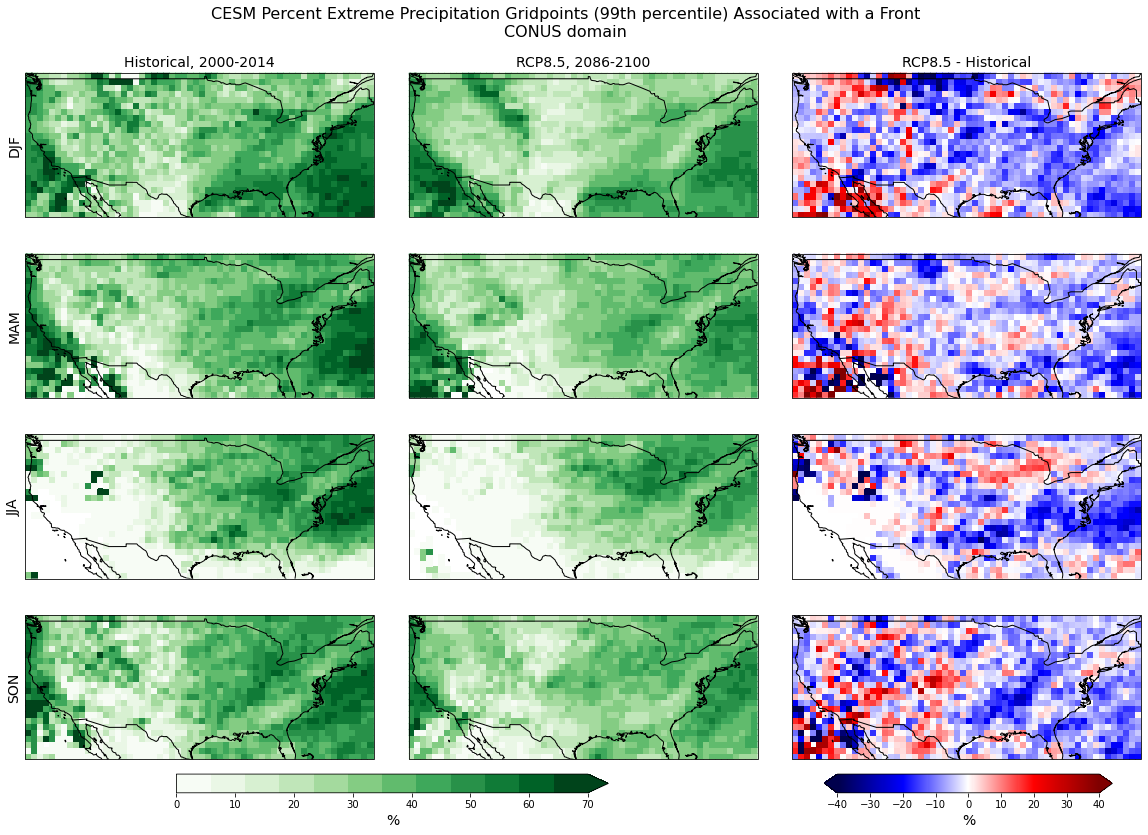

In [54]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
#vmax = 60 # 90,95th percentiles
vmax = 70 # 99th percentile

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason.sel(season=season), coord=npercentPEx_time_CONUS_byseason.lon)
    lat = npercentPEx_time_CONUS_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_rcp.sel(season=season), coord=npercentPEx_time_CONUS_byseason_rcp.lon)
    lat = npercentPEx_time_CONUS_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
# 90, 95th percentiles
#vmin2=-20
#vmax2=20
# 99th percentile
vmin2=-40
vmax2=40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (95th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (99th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')

### Adding PEx grid/time point plots

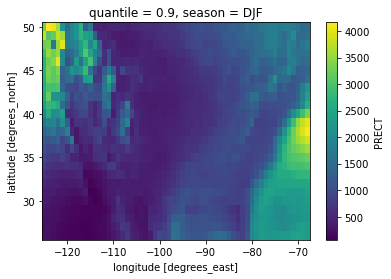

In [78]:
PExgridpoints_time_CONUS_byseason.sel(season='DJF').plot()

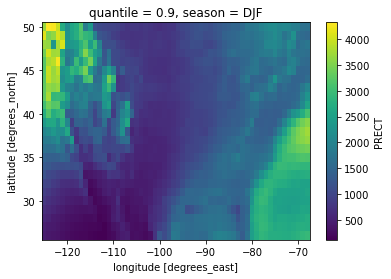

In [75]:
PExgridpoints_time_CONUS_byseason_rcp.sel(season='DJF').plot()

In [55]:
# calculating the % changes in PEx (w/o fronts)
PExgridpoints_time_CONUS_byseason_perdiff = 100*(PExgridpoints_time_CONUS_byseason_rcp - PExgridpoints_time_CONUS_byseason)/PExgridpoints_time_CONUS_byseason

In [56]:
# persist for plotting
PExgridpoints_time_CONUS_byseason_perdiff = PExgridpoints_time_CONUS_byseason_perdiff.persist()

In [72]:
# absolute changes (units = number of gridpoints, not that helpful to visualize)
PExgridpoints_time_CONUS_byseason_diff = PExgridpoints_time_CONUS_byseason_rcp - PExgridpoints_time_CONUS_byseason
PExgridpoints_time_CONUS_byseason_diff = PExgridpoints_time_CONUS_byseason_diff.persist()

### Calculating the changes in fronts (usually done in a different notebook)

In [33]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(srates_clim_CONUS.lat))
    weights.name = "weights"
    srates_clim_CONUS_weighted = srates_clim_CONUS.weighted(weights)
    srates_clim_CONUS_weighted_mean = srates_clim_CONUS_weighted.mean(("lon","lat"))
    srates_clim_stdev_CONUS_weighted = srates_clim_stdev_CONUS.weighted(weights)
    srates_clim_stdev_CONUS_weighted_mean = srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(srates_clim_CONUS, srates_clim_stdev_CONUS, srates_clim_CONUS_weighted_mean, srates_clim_stdev_CONUS_weighted_mean)

In [34]:
# cesm rates with a modified 15-year climatology to match RCP #years (2000-2014)
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
cesm_fullmod_rates_file = "cesm_fronts_2000-2014_frontRates_viaPolylines_customgrid.nc"
cesm_fullmod_srates_clim_CONUS, cesm_fullmod_srates_clim_stdev_CONUS, cesm_fullmod_srates_clim_CONUS_mean, cesm_fullmod_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_fullmod_rates_file, "MERRA")

# cesm rcp8.5 results
cesm_rcp85_rates_file = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc" # generated via poylines
cesm_rcp85_srates_clim_CONUS, cesm_rcp85_srates_clim_stdev_CONUS, cesm_rcp85_srates_clim_CONUS_mean, cesm_rcp85_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rcp85_rates_file, "MERRA")

cesm_srates_clim_CONUS_diff = cesm_rcp85_srates_clim_CONUS - cesm_fullmod_srates_clim_CONUS

In [66]:
# calculating spearman rank correlations to add to plots
test_spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), y=(cesm_srates_clim_CONUS_diff*7)[0,4,:,:])
test_spear

SpearmanrResult(correlation=0.5934669275215751, pvalue=1.0698553984693948e-138)

In [67]:
test_spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'))
test_spear

SpearmanrResult(correlation=-0.05064395306370778, pvalue=0.05385034877123723)

In [68]:
# string formatting for correlation labels
spearstr = r'$\rho$ = '+str(round(test_spear.correlation,2))
spearstr

'$\\rho$ = -0.05'

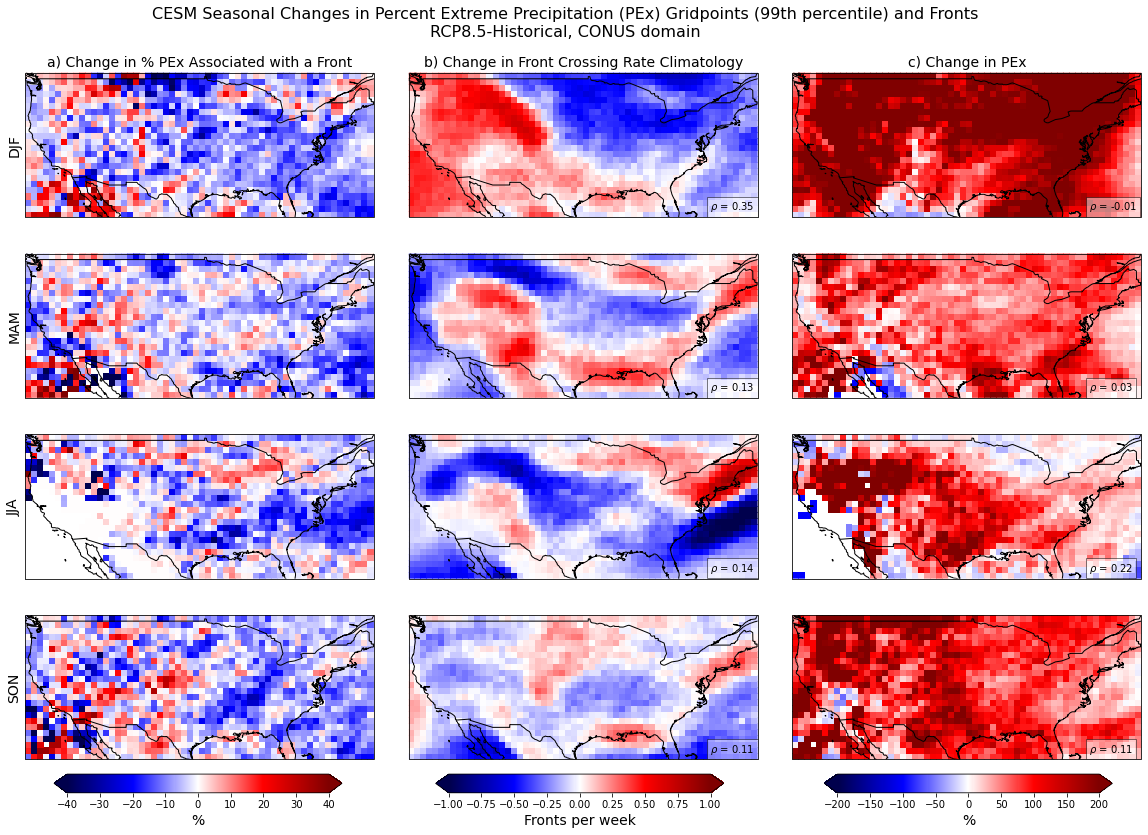

In [58]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
# 90, 95th percentiles
#vmin1=-20
#vmax1=20
# 99th percentile
vmin1=-40
vmax1=40

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts    
vmin2=-1
vmax2=1
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Change in Front Crossing Rate Climatology', fontsize=14) 
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff*7)[i,4,:,:])
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    axs[i,1].text(0.865, 0.05, spearstr, transform=axs[i,1].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5))
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

# third panel: change in PEx 
# 90, 95th percentiles
#vmin3=-100
#vmax3=100
# 99th percentile
vmin3=-200
vmax3=200
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Change in PEx', fontsize=14)
    field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    #field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_diff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_diff.lon)
    #lat = PExgridpoints_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season=season), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season))
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5))
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('%', fontsize=14)  
    
# add title
#fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (90th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)
#fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (95th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (99th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')

In [45]:
# Other plotting ideas
# first panel: change in PEx and Front as above

# second panel: spatial pattern correlation of front frequency with first panel (as a map)

# third panel: spatial pattern correlation of change in PEx with first panel (as a map)

# Also, could look at high-res (0.25deg) version of panel c) to investigate changes in PEx in the model

In [62]:
# spatial pattern correlation
from scipy import signal
corr_test = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='same', boundary='fill')
corr_test
# how to interpret these numbers? do they need to be rescaled/normalized somehow?

array([[  7108.01846539,  10548.16615882,  12728.60824858, ...,
        -18428.55944125, -17975.59902491, -17909.88828714],
       [  7010.05074311,   9334.95058829,  11521.4715763 , ...,
        -18083.04086214, -17839.88071637, -17659.4517094 ],
       [  6478.8974631 ,   8419.73664346,   9972.18513611, ...,
        -18206.96384032, -18259.83948993, -17972.95137546],
       ...,
       [  8316.28924025,   8644.11223315,   8396.53626996, ...,
        -14716.95810583, -15415.2616316 , -14820.6341486 ],
       [  6947.74468098,   6625.40378026,   5994.19334058, ...,
        -10919.5658539 , -12370.32145513, -12694.30296724],
       [  5923.41228541,   5375.66184696,   4859.5991379 , ...,
         -6176.37404418,  -7182.10957243,  -8614.46218818]])

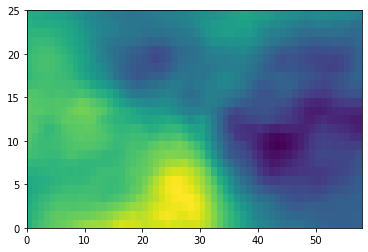

In [63]:
plt.pcolor(corr_test)

In [72]:
# mode='valid' gives a single number?
corr_test = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='valid', boundary='fill')
corr_test

array([[-3769.92659385]])

In [65]:
# what is the difference using boundary='symm'? output is definitely different
corr_symm = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='same', boundary='symm')
corr_symm
# also a boundary='wrap' option...

array([[ 23923.24191219,  25411.70277747,  24802.72510358, ...,
        -13239.73667558, -15054.65132062, -15649.83558099],
       [ 19023.14199234,  21715.36420436,  23280.7431748 , ...,
         -8249.13240684, -10337.00949212, -11068.51453244],
       [ 15801.00875758,  18380.00230924,  20147.4915153 , ...,
         -6078.95441115,  -6757.04606746,  -7099.79920542],
       ...,
       [  -200.58262876,   4860.10555447,   8386.3960937 , ...,
        -18925.0029437 , -17308.74470222, -15031.80885584],
       [ -6012.90987457,   -704.56573703,   2868.07823336, ...,
        -15542.41847282, -14023.00778269, -11837.42924175],
       [-11735.36671231,  -6717.67562198,  -2472.21463554, ...,
        -10389.84133668,  -8480.4832926 ,  -7305.70425711]])

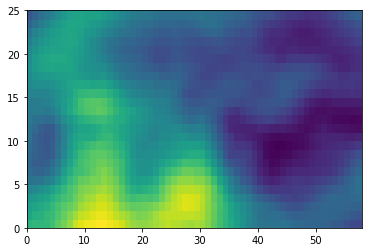

In [66]:
plt.pcolor(corr_symm)

In [68]:
corr_test_fronts = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), cesm_srates_clim_CONUS_diff[0,4,:,:], mode='same', boundary='fill')
corr_test_fronts
# scale of numbers is very different here

array([[-34.02684229, -31.02508938, -29.19678615, ..., -26.06786052,
        -31.97249809, -37.20272489],
       [-31.64991679, -28.15192885, -25.16184323, ..., -34.59658333,
        -40.20643337, -45.04836551],
       [-29.51567704, -25.66565864, -21.99386837, ..., -42.93102423,
        -48.2888662 , -52.62923128],
       ...,
       [ 26.74445842,  30.69230389,  34.45933308, ..., -83.25288607,
        -80.10881936, -75.22622885],
       [ 24.25894999,  27.14500036,  30.34352987, ..., -74.024844  ,
        -71.42070505, -67.01065928],
       [ 19.99890707,  22.85529487,  25.35927075, ..., -64.95092391,
        -63.06845199, -58.99291268]])

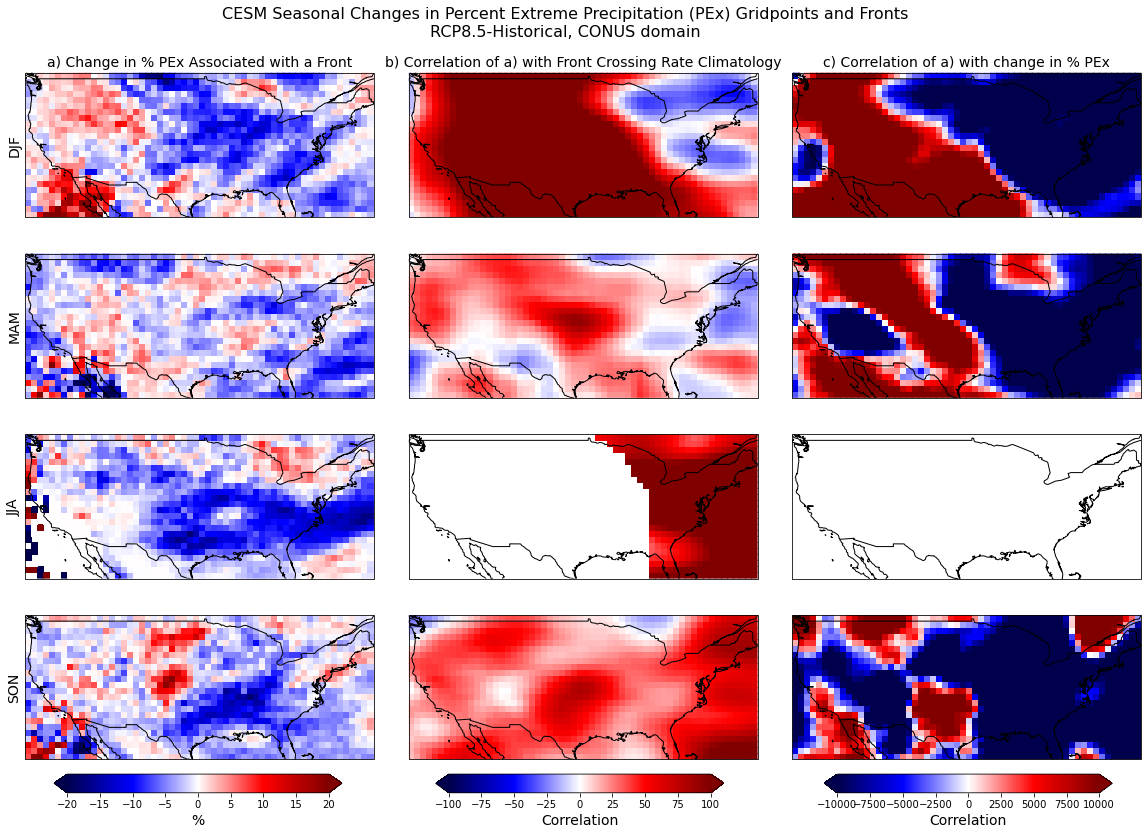

In [71]:
# scales are a bit weird here, especially for correlations of percentage diffs
# also some seasons don't plot / get cut off?
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
vmin1=-20
vmax1=20

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts correlation with first panel  
vmin2=-100
vmax2=100
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Correlation of a) with Front Crossing Rate Climatology', fontsize=14) 
    corr = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season=season), cesm_srates_clim_CONUS_diff[i,4,:,:], mode='same', boundary='symm')
    field, lon = add_cyclic_point(corr, coord=cesm_srates_clim_CONUS_diff.lon)
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Correlation', fontsize=14)

# third panel: change in PEx correlation with first panel
vmin3=-10000
vmax3=10000
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Correlation of a) with change in % PEx', fontsize=14)
    corr = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season=season), PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), mode='same', boundary='symm')
    field, lon = add_cyclic_point(corr, coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('Correlation', fontsize=14)  


    
# add title
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff_withfronts_andPEx.png', bbox_inches='tight')

In [59]:
client.close()
cluster.close()